In [ ]:
!pip install -Iv librosa==0.7.2

Streaming output truncated to the last 5000 lines.
  Found link https://files.pythonhosted.org/packages/d2/8e/3aaa9c7010c6943b23344b5854e5e56d10458b67fb23f1ee86c549f58286/numpy-1.7.2.tar.gz#sha256=f963f6a5e21438dede6b4412cf9aaa230c145038a6d234aefdd70d20152f8d53 (from https://pypi.org/simple/numpy/), version: 1.7.2
  Found link https://files.pythonhosted.org/packages/6e/47/816d1bfd24514423080889ce026846d028a3fb2507c2eb4a0c2da62df442/numpy-1.7.2.zip#sha256=76fe1164ed3686a3545c9d701933968773559de9441974e955cd1918bcd4ba2d (from https://pypi.org/simple/numpy/), version: 1.7.2
  Skipping link: none of the wheel's tags match: cp26-cp26m-manylinux1_x86_64: https://files.pythonhosted.org/packages/b8/15/0128818730e51c7906d60f4b5c098f7991c4021f20d0d2f61598fc8a4904/numpy-1.8.0-cp26-cp26m-manylinux1_x86_64.whl#sha256=1688709ed36f6064f92bdb446a291340910bcc7a7da1496041c56fc8c210239c (from https://pypi.org/simple/numpy/)
  Skipping link: none of the wheel's tags match: cp26-cp26mu-manylinux1_x86_64: h

In [ ]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import librosa
import librosa.display
import os

In [ ]:
plt.ioff()  # Turn off automatic image display

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/bosch/processed-instr

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/bosch/processed-instr


In [ ]:
%ls

acoustic/     country/     garage/     indian/  pop/         salsa/
afrobeat/     dance/       gospel/     indie/   punk/        samba/
alternative/  disco/       grunge/     jazz/    reggae/      style.png
blues/        dubstep/     hard-rock/  latino/  reggaeton/   tango/
classical/    electronic/  hip-hop/    log/     rock/        techno/
content.png   funk/        house/      metal/   rockabilly/  trip-hop/


In [ ]:
def load_by_index(genre: str, index: int) -> np.array:
  """Load a melspectogram stored on disk."""
  path = f'{genre}/{os.listdir(genre)[0]}'
  S = np.load(path)
  tensor = tf.convert_to_tensor(S)
  tensor = tf.expand_dims(tensor, axis=2)
  tensor = tf.concat([tensor, tensor, tensor], axis=2)
  # Add batch dimension
  tensor = tf.expand_dims(tensor, axis=0)
  return tensor

In [ ]:
content_image = load_by_index('acoustic', 0)
style_image = load_by_index('hip-hop', 0)

In [ ]:
vgg = tf.keras.applications.VGG19(
    include_top=False, 
    weights='imagenet', 
    input_shape=(128, 1292, 3)
)

for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(
      include_top=False, 
      weights='imagenet', 
      input_shape=(128, 1292, 3)
  )
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 128, 1292, 64)
  min:  0.0
  max:  4050713.8
  mean:  3456.4185

block2_conv1
  shape:  (1, 64, 646, 128)
  min:  0.0
  max:  20757652.0
  mean:  29765.467

block3_conv1
  shape:  (1, 32, 323, 256)
  min:  0.0
  max:  50835496.0
  mean:  53081.406

block4_conv1
  shape:  (1, 16, 161, 512)
  min:  0.0
  max:  63293124.0
  mean:  395414.34

block5_conv1
  shape:  (1, 8, 80, 512)
  min:  0.0
  max:  7019394.0
  mean:  76527.945



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0001555874
    max:  27326062.0
    mean:  1997882.8

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  2516738000.0
    mean:  91555180.0

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  7647846000.0
    mean:  122037120.0

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  42426720000.0
    mean:  1418571100.0

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2265565200.0
    mean:  13350206.0

Contents:
   block5_conv2
    shape:  (1, 8, 80, 512)
    min:  0.0
    max:  105953.375
    mean:  1071.4158


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])

In [ ]:
def plot_melspectogram(S: np.array, title: str):
  plt.figure(figsize=(10, 4))
  S_dB = librosa.power_to_db(S, ref=np.max)
  librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel', sr=22050,
                            fmax=8000)
  plt.colorbar(format='%+2.0f dB')
  plt.title(title)
  plt.tight_layout()
  plt.show()

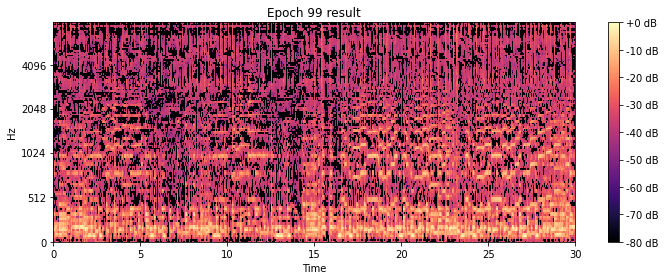

Train step: 101
Total time: 240.5


In [ ]:
import time
start = time.time()

epochs = 100
steps_per_epoch = 1

step = 1
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  plot_melspectogram(image[0, :, :, 0].numpy(), f'Epoch {n} result')
  print("Train step: {}".format(step))
  time.sleep(2)
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

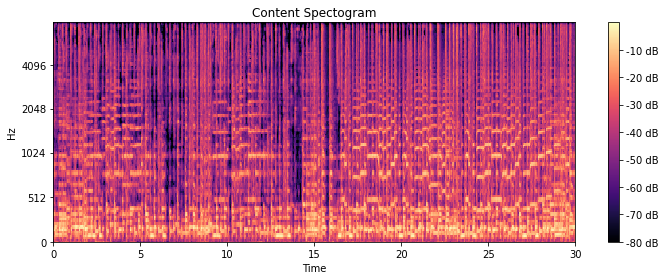

In [ ]:
plot_melspectogram(content_image[0, :, :, 0], 'Content Spectogram')

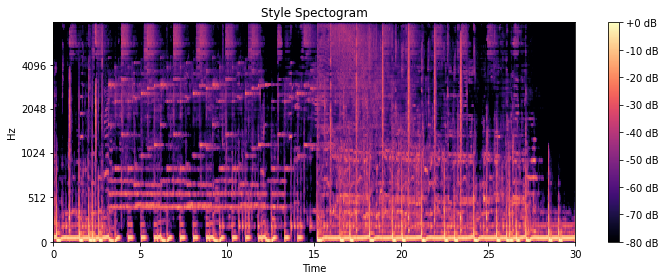

In [ ]:
plot_melspectogram(style_image[0, :, :, 0], 'Style Spectogram')

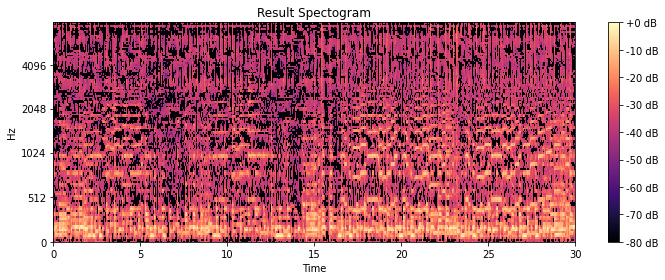

In [ ]:
plot_melspectogram(image[0, :, :, 0], 'Result Spectogram')

In [ ]:
# y = librosa.feature.inverse.mel_to_audio(image[0, :, :, 0].numpy())